In [1]:
!nvidia-smi

Sun May  9 20:17:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-cn_dnka6
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-cn_dnka6
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=133142986d0803b53fbfffdf2e1f4485beffaf800badda39e380e6e84456b36a
  Stored in directory: /tmp/pip-ephem-wheel-cache-f3gv9ivp/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install efficientnet

     |████████████████████████████████| 50 kB 537 kB/s 
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate,GaussianBlur, RGBShift, FancyPCA, Resize
)

import efficientnet.tfkeras as efn
import tensorflow.keras.models as M
import tensorflow.keras.layers as L

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [5]:
!pip freeze > requirements.txt

# Основные настройки

In [6]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [7]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [8]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [11]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


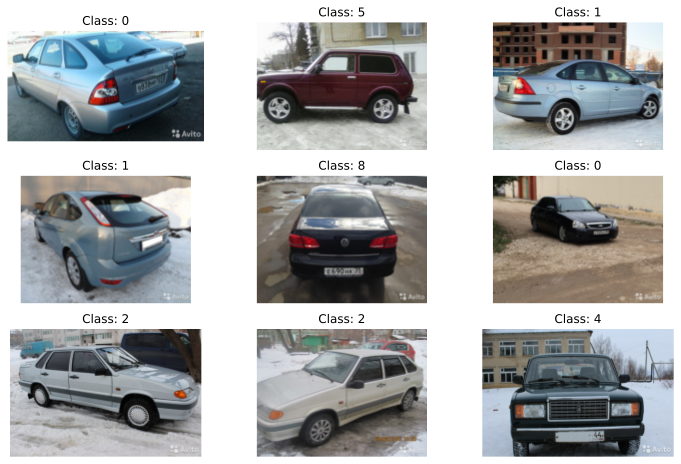

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

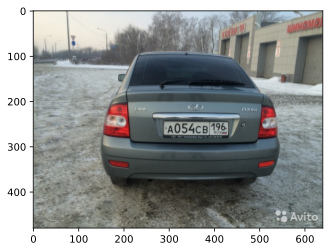

(640, 480)

In [13]:
image = PIL.Image.open(PATH+'/train/0/100389.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [14]:
# Подключаем библиотеку albumentations с помощью ImageDataAugmentor

AUGMENTATIONS = albumentations.Compose([
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(p=0.5),
            Rotate(limit=30,interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
            GaussianBlur(p=0.05),
            HueSaturationValue(p=0.5),
            RGBShift(p=0.5),
            FancyPCA(alpha=0.1, always_apply=False, p=0.5),
            Resize(IMG_SIZE, IMG_SIZE)
        ])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT)

test_datagen = ImageDataAugmentor(rescale=1. / 255)

### Генерация данных

In [15]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


# Построение модели

### Загружаем предобученную сеть Efficientnet-b6:

In [16]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

165527552/165527152 [==============================] - 3s 0us/step


In [17]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [18]:
base_model.trainable = False

In [19]:
# Устанавливаем новую "голову"
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) 
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
______________________________________

In [21]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [22]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

Обучаем:

In [23]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
827/827 [==============================] - 214s 238ms/step - loss: 1.8891 - accuracy: 0.3680 - val_loss: 1.1082 - val_accuracy: 0.5998

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
827/827 [==============================] - 195s 236ms/step - loss: 1.3877 - accuracy: 0.5200 - val_loss: 1.0583 - val_accuracy: 0.6230

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
827/827 [==============================] - 195s 236ms/step - loss: 1.2640 - accuracy: 0.5497 - val_loss: 0.9883 - val_accuracy: 0.6449

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
827/827 [==============================] - 196s 237ms/step - loss: 1.2222 - accuracy: 0.5644 - val_loss: 0.9801 - val_accuracy: 0.6466

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
827/827 [==============================] - 197s 238ms/step - loss: 1.2116 - accuracy: 0.5701 - val_loss: 0.9721 - val_accuracy: 0.6496

Epoch 00005: saving model to best_model.hdf5


In [24]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [25]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


146/146 [==============================] - 29s 197ms/step - loss: 0.9643 - accuracy: 0.6483
Accuracy: 64.83%


Точность бейслайн-модели на основе Xception без заморозки слоев составила 92.01%. 
Точность этой же сети с аугментацией составила 92.40% - думал будет больше.
Замороженная сеть efficientnet-b6 только с обученной головой дала точность 65.56%, с BatchNormalization и заморозкой одной половины преобученных слоев - 93.52%. Заморозив другую половину получил точность 94.59%.

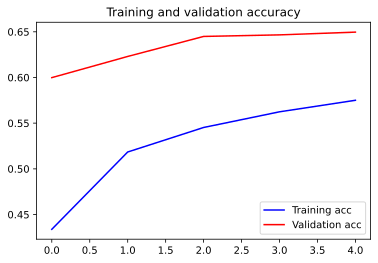

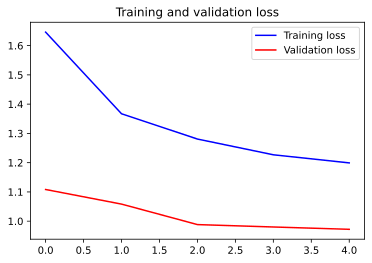

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Step 2

In [27]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [28]:
base_model.trainable = True

fine_tune_at = len(base_model.layers)//2

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [29]:
len(base_model.trainable_variables)

291

In [30]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 38,289,632
Non-trainable params: 3,264,178
____________________________________

In [32]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
827/827 [==============================] - 250s 280ms/step - loss: 1.4285 - accuracy: 0.5100 - val_loss: 0.4245 - val_accuracy: 0.8416

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
827/827 [==============================] - 254s 306ms/step - loss: 0.5528 - accuracy: 0.8039 - val_loss: 0.2997 - val_accuracy: 0.8961

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
827/827 [==============================] - 231s 279ms/step - loss: 0.3770 - accuracy: 0.8663 - val_loss: 0.2273 - val_accuracy: 0.9098

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
827/827 [==============================] - 230s 278ms/step - loss: 0.2970 - accuracy: 0.8932 - val_loss: 0.1999 - val_accuracy: 0.9270

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
827/827 [==============================] - 230s 278ms/step - loss: 0.2410 - accuracy: 0.9139 - val_loss: 0.1981 - val_accuracy: 0.9292

Epoch 00005: saving model to best_model.hdf5


In [33]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [34]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 28s 194ms/step - loss: 0.1950 - accuracy: 0.9266
Accuracy: 92.66%


## Step 3

In [35]:
base_model.trainable = True

In [36]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [37]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
827/827 [==============================] - 439s 502ms/step - loss: 0.2212 - accuracy: 0.9207 - val_loss: 0.1661 - val_accuracy: 0.9399

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
827/827 [==============================] - 411s 497ms/step - loss: 0.1730 - accuracy: 0.9377 - val_loss: 0.1667 - val_accuracy: 0.9433

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
827/827 [==============================] - 413s 499ms/step - loss: 0.1733 - accuracy: 0.9407 - val_loss: 0.1528 - val_accuracy: 0.9468

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
827/827 [==============================] - 410s 496ms/step - loss: 0.1431 - accuracy: 0.9523 - val_loss: 0.1521 - val_accuracy: 0.9502

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
827/827 [==============================] - 412s 498ms/step - loss: 0.1428 - accuracy: 0.9461 - val_loss: 0.1464 - val_accuracy: 0.9519

Epoch 00005: saving model to best_model.hdf5


In [38]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [39]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 29s 196ms/step - loss: 0.1572 - accuracy: 0.9472
Accuracy: 94.72%


## TTA

In [40]:
model.load_weights('best_model.hdf5')

In [41]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, 
    horizontal_flip=False
)

In [42]:
test_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [43]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, steps = len(test_generator), verbose=1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


418/418 [==============================] - 117s 279ms/step


In [44]:
predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [45]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

418/418 [==============================] - 100s 234ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Accuracy: 0.00%


# Предсказание на тестовых данных

In [46]:
test_sub_generator.samples

6675

In [47]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

418/418 [==============================] - 50s 118ms/step


In [48]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [49]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


In [50]:
# Clean PATH
import shutil
shutil.rmtree(PATH)